# Preparing the dataset

In [ ]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import string
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#!pip install numpy==1.19.3

In [ ]:
import numpy
numpy.version.version

'1.19.5'

In [ ]:
! pip install pymagnitude
from pymagnitude import Magnitude, MagnitudeUtils

     |████████████████████████████████| 5.4MB 6.6MB/s 
  Created wheel for pymagnitude: filename=pymagnitude-0.1.143-cp37-cp37m-linux_x86_64.whl size=360626360 sha256=9af9821a6ec9c75d3e84540c0d109ce537c28328b14d74f4853ccd920c3f4e8d
  Stored in directory: /root/.cache/pip/wheels/bb/b2/16/f88eb50800667ffe23d509c7e2157923a08d10ed6d6410124f
Successfully built pymagnitude


In [ ]:
glove = Magnitude(MagnitudeUtils.download_model('glove/medium/glove.6B.{}d'.format(100),download_dir='/content/drive/MyDrive/Projects/Machine Comprehension'))
fasttext = Magnitude(MagnitudeUtils.download_model('fasttext/medium/wiki-news-300d-1M-subword',download_dir='/content/drive/MyDrive/Projects/Machine Comprehension'))
vectors = Magnitude(glove, fasttext)

In [ ]:
json_file='/content/drive/MyDrive/train-v2.0.json'
with open(json_file) as f:
  data = json.load(f)

In [ ]:
# Refine the data
context=[]
ans_start=[]
ans_txt=[]
question=[]

for i in data['data']:
  for j in i['paragraphs']:
    c=j['context']
    if len(c.split())<300:
      for k in j['qas']:
        q=k['question']
        #a=k['answers'][0]
        is_pos=k['is_impossible']
        if is_pos==False:
          a=k['answers'][0]
          context.append(c)
          question.append(q)
          ans_txt.append(a['text'])
          ans_start.append(a['answer_start'])

In [ ]:
# Use tensorflow preprocessing APIs

# create tokenizer

dataset=context+question
tokenizer=tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(dataset)

# Tokenize the data

contexti=tokenizer.texts_to_sequences(context)
questioni=tokenizer.texts_to_sequences(question)
ansi=tokenizer.texts_to_sequences(ans_txt)

# Calculate the start and end index
start_ind=[]
end_ind=[]
for i in range(len(context)):
  st=len(tokenizer.texts_to_sequences([context[i][:ans_start[i]]])[0])
  start_ind.append(st)
  end_ind.append(st+len(ansi[i])-1)


# Validating results
print('Actual answers:\n',ans_txt[200:210])
txt=[contexti[i][start_ind[i]:end_ind[i]+1] for i in range(200,210,1)]
t=[]
for j in txt:
  t.append([tokenizer.index_word[i] for i in j])
print('\n\n')
print('Answers by indexes:\n',t)

Actual answers:
 ['2010', '2010', 'the Great Wall of China', '2010', 'her mother', 'During the break', 'nine months', 'a hiatus', 'her mother', 'her father']



Answers by indexes:
 [['2010'], ['2010'], ['the', 'great', 'wall', 'of', 'china'], ['2010'], ['her', "mother's"], ['during', 'the', 'break'], ['nine', 'months'], ['a', 'hiatus'], ['her', "mother's"], ['her', 'father']]


In [ ]:
# Add padding token to tokenizer
tokenizer.word_index['<PAD>']=0
tokenizer.index_word[0]='<PAD>'

In [ ]:
# Use NLTK

# tokenize the data
def tokenize(data):
  processed_data=[]
  for i in data:
    temp=i.lower()
    temp="".join([char for char in temp if char not in string.punctuation])
    processed_data.append(nltk.word_tokenize(temp))
  return processed_data

# Tokenize the data
processed_con=tokenize(context)
processed_que=tokenize(question)
processed_ans=tokenize(ans_txt)


# Calculate the start and end index
start_ind=[]
end_ind=[]
for i in range(len(context)):
  st=len(tokenize([context[i][:ans_start[i]]])[0])
  start_ind.append(st)
  end_ind.append(st+len(processed_ans[i])-1)

# Validating results
print('Actual answers:\n',ans_txt[200:210])
txt=[processed_con[i][start_ind[i]:end_ind[i]+1] for i in range(200,210,1)]
print('\n\n')
print('Answers by indexes:\n',txt)

For context:



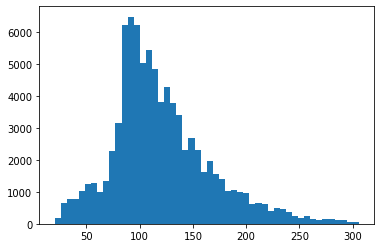



Max Length: 306


In [ ]:
# Padding the data
print('For context:\n')

lenths=[len(i) for i in contexti]
plt.hist(lenths,bins=50)
plt.show()

print('\n\nMax Length:',max(lenths))

For question:



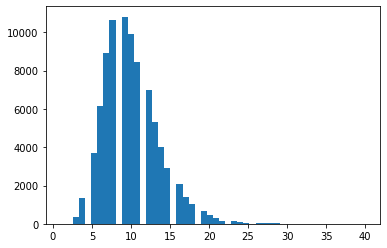



Max Length: 40


In [ ]:
# Padding the data
print('For question:\n')

lenths=[len(i) for i in questioni]
plt.hist(lenths,bins=50)
plt.show()

print('\n\nMax Length:',max(lenths))

In [ ]:
# Padding
con_pad=tf.keras.preprocessing.sequence.pad_sequences(contexti,padding='post',truncating='post')
que_pad=tf.keras.preprocessing.sequence.pad_sequences(questioni,padding='post',truncating='post')
con_pad=con_pad[:-8]
que_pad=que_pad[:-8]
start_ind=start_ind[:-8]
end_ind=end_ind[:-8]

In [ ]:
# Create embedding matrix
def create_mat(token,emb_dim,vect):
  mat=np.zeros((len(token.word_index)+1,emb_dim))
  for i in range(1,len(token.word_index)+1):
    emb=vect.query([token.index_word[i]])
    emb=emb.reshape((emb_dim))
    mat[i]=emb
  return mat

In [ ]:
# test the function
emb_mat=create_mat(tokenizer,400,vectors)

In [ ]:
# Alternative create embedding matrix

def create_matrix(token,emb_dim,vect):
  mat=np.zeros((len(token.word_index)+1,emb_dim))
  a=list(token.index_word.values())
  emb=vectors.query(a)
  for i in range(1,len(token.word_index)+1):
    mat[i]=emb[i-1]
  return mat

In [ ]:
# Test the function
emb_mat2=create_matrix(tokenizer,400,vectors)

In [ ]:
(emb_mat2==emb_mat).all()

True

In [ ]:
# Save the tokenizer
import pickle

# saving
with open('/content/drive/MyDrive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('/content/drive/MyDrive/Projects/MachineComprehension/tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)

In [ ]:
tokenizer.word_index['<OOV>']

1

In [ ]:
emb_mat2.shape

(90918, 400)

In [ ]:
(len(start_ind)-8)/80

1077.9

In [ ]:
len(start_ind)/80

1078.0

# Define model components

##Highway

In [ ]:
'''
class Highway(tf.keras.Model):
  def __init__(self,d,gate_bias=-1,activation='sigmoid'):
    super(Highway,self).__init__()
    initializer = tf.keras.initializers.Constant(gate_bias)
    self.transform_gate=tf.keras.layers.Dense(d,activation='sigmoid',bias_initializer=initializer)
    self.lamb=tf.keras.layers.Lambda(lambda x:1.0-x)
    self.normal=tf.keras.layers.Dense(d,activation)


  def call(self,inputs):
    normal=self.normal(inputs)
    transform=self.transform_gate(inputs)
    carry=self.lamb(transform)

    # implementing the gates
    carry_gate =tf.keras.layers.Multiply()([carry,inputs])
    transform_gate=tf.keras.layers.Multiply()([normal,transform])

    # final addition
    out=tf.keras.layers.Add()([transform_gate,carry_gate])
    return out

'''


"\nclass Highway(tf.keras.Model):\n  def __init__(self,d,gate_bias=-1,activation='sigmoid'):\n    super(Highway,self).__init__()\n    initializer = tf.keras.initializers.Constant(gate_bias)\n    self.transform_gate=tf.keras.layers.Dense(d,activation='sigmoid',bias_initializer=initializer)\n    self.lamb=tf.keras.layers.Lambda(lambda x:1.0-x)\n    self.normal=tf.keras.layers.Dense(d,activation)\n\n\n  def call(self,inputs):\n    normal=self.normal(inputs)\n    transform=self.transform_gate(inputs)\n    carry=self.lamb(transform)\n\n    # implementing the gates\n    carry_gate =tf.keras.layers.Multiply()([carry,inputs])\n    transform_gate=tf.keras.layers.Multiply()([normal,transform])\n\n    # final addition\n    out=tf.keras.layers.Add()([transform_gate,carry_gate])\n    return out\n\n"

In [ ]:
def highway(inp,gate_bias=-1,activation='relu'):
  d=inp.shape[-1]
  initializer = tf.keras.initializers.Constant(gate_bias)
  normal=tf.keras.layers.Dense(d,activation)(inp)
  transform=tf.keras.layers.Dense(d,activation='sigmoid',bias_initializer=initializer)(inp)
  carry=tf.keras.layers.Lambda(lambda x:1.0-x)(transform)
  

  # implementing the gates
  carry_gate =tf.keras.layers.Multiply()([carry,inp])
  transform_gate=tf.keras.layers.Multiply()([normal,transform])

  #final Addition
  out=tf.keras.layers.Add()([transform_gate,carry_gate])

  return out



In [ ]:
# testing the highway
a=tf.random.uniform((5,4))
inp=tf.keras.Input((5,4))
#high=Highway(4,activation='relu')
out=highway(inp)
out

<KerasTensor: shape=(None, 5, 4) dtype=float32 (created by layer 'add')>

## Attention Block:

   1. Similarity matrix (Filter)
   2. Context to Query
   3. Query to Context
   
Merge all of them together 

###Similarity Matrix

In [ ]:
class Similarity_mat(tf.keras.layers.Layer):
  def __init__(self):
    super(Similarity_mat,self).__init__()
  
  def build(self,input_shape):
    #print(input_shape)
    d=input_shape[0][-1]*3

    self.kernal=self.add_weight(name='kernal',shape=(d,1))
    self.bias=self.add_weight(name='Bias',shape=([1]))
  
  def call(self,inputs):
    con,que=inputs
    con_ext=tf.concat([[1], [con.shape[1]], [1,1]], 0)
    que_ext=tf.concat([[1,1], [que.shape[1]], [1]], 0)

    con_sim=tf.tile(tf.expand_dims(con,axis=2),que_ext)
    que_sim=tf.tile(tf.expand_dims(que,axis=1),con_ext)

    sim_mat=con_sim*que_sim
    conc_mat=tf.concat([con_sim,que_sim,sim_mat],axis=-1)

    out=tf.squeeze(tf.matmul(conc_mat,self.kernal),axis=-1)+self.bias
    return out

In [ ]:
# Test the layer
con=tf.random.uniform((2,10,4))
que=tf.random.uniform((2,5,4))

l=Similarity_mat()
o=l([con,que])
o

<tf.Tensor: shape=(2, 10, 5), dtype=float32, numpy=
array([[[ 0.49783552,  0.11556756,  0.29361224,  0.9529166 ,
          1.0999489 ],
        [ 0.7349323 ,  0.366589  ,  0.5633375 ,  1.320235  ,
          1.5197687 ],
        [ 0.8875408 ,  0.40162706,  0.63360584,  1.4265683 ,
          1.6192727 ],
        [ 0.8060663 ,  0.3998176 ,  0.58433825,  1.3597357 ,
          1.5681778 ],
        [ 0.6999629 ,  0.04197657,  0.42067206,  1.2547152 ,
          1.404132  ],
        [ 0.6536979 , -0.1211319 ,  0.31689817,  1.2050028 ,
          1.3522646 ],
        [ 0.7547089 ,  0.11066103,  0.4653114 ,  1.3085297 ,
          1.4723039 ],
        [ 0.7962766 ,  0.0752809 ,  0.48582315,  1.235604  ,
          1.3160194 ],
        [ 0.6330513 ,  0.14382803,  0.3585714 ,  1.0500695 ,
          1.1891322 ],
        [ 0.35326886, -0.398278  ,  0.02123952,  0.77507967,
          0.8536968 ]],

       [[ 0.4129343 ,  0.38940346,  0.5592282 ,  1.0748017 ,
          0.6873298 ],
        [ 0.4808188 , 

### Context to Query

It signifies which query words are more significant to each context word

In [ ]:
def c2q(sim_mat,que):
  # take the sigmoid of similarity matrix
  x=tf.keras.activations.softmax(sim_mat,axis=-1)
  x=tf.expand_dims(x,axis=-1)
  que_ex=tf.expand_dims(que,axis=1)

  out=x*que_ex
  out=tf.reduce_sum(out,axis=2)
  return out

In [ ]:
# Test the function

sim_mat=tf.random.uniform((2,10,5))
que=tf.random.uniform((2,5,4))
o=c2q(sim_mat,que)
o

<tf.Tensor: shape=(2, 10, 4), dtype=float32, numpy=
array([[[0.42768022, 0.48250565, 0.37371314, 0.54764193],
        [0.49119115, 0.514154  , 0.4152186 , 0.5008731 ],
        [0.41522652, 0.51432526, 0.365065  , 0.54043955],
        [0.4346239 , 0.54420245, 0.36954585, 0.5658714 ],
        [0.43866363, 0.45306605, 0.41086173, 0.46359307],
        [0.44107574, 0.49781156, 0.4003593 , 0.4592835 ],
        [0.4846804 , 0.51774055, 0.41462913, 0.5162557 ],
        [0.48346603, 0.48077905, 0.399416  , 0.54729474],
        [0.43306082, 0.4721166 , 0.3972862 , 0.48749408],
        [0.42231798, 0.42701718, 0.42306736, 0.4248899 ]],

       [[0.34485194, 0.41136712, 0.412336  , 0.5772737 ],
        [0.30558333, 0.4659555 , 0.39514303, 0.5787742 ],
        [0.37816307, 0.37358132, 0.432589  , 0.629611  ],
        [0.36269698, 0.44326115, 0.37489223, 0.5658411 ],
        [0.35079128, 0.38874057, 0.4509751 , 0.67269313],
        [0.31793165, 0.4389173 , 0.42277405, 0.6345227 ],
        [0.3440861

### Query to context

It signifies which word in question is most significant to each context word

In [ ]:

def q2c(sim_mat,con):
  x=tf.math.reduce_max(sim_mat,axis=-1)
  x=tf.keras.activations.softmax(x,axis=-1)
  x=tf.expand_dims(x,axis=-1)

  x=x*con
  x=tf.math.reduce_sum(x,axis=1)
  x=tf.expand_dims(x,axis=1)
  dim=[1,con.shape[1],1]
  x=tf.tile(x,dim)
  return x


In [ ]:
# testing the function
sim_mat=tf.random.uniform((2,10,5))
con=tf.random.uniform((2,10,4))
out=q2c(sim_mat,con)
out

<tf.Tensor: shape=(2, 10, 4), dtype=float32, numpy=
array([[[0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947],
        [0.48802045, 0.5563464 , 0.5317598 , 0.49655947]],

       [[0.30607775, 0.58526516, 0.3651368 , 0.3494672 ],
        [0.30607775, 0.58526516, 0.3651368 , 0.3494672 ],
        [0.30607775, 0.58526516, 0.3651368 , 0.3494672 ],
        [0.30607775, 0.58526516, 0.3651368 , 0.3494672 ],
        [0.30607775, 0.58526516, 0.3651368 , 0.3494672 ],
        [0.30607775, 0.58526516, 0.3651368 , 0.3494672 ],
        [0.3060777

### Merge the attention matrices

In [ ]:
def merge(con,q2c,c2q):
  con_u=con*c2q
  con_h=con*q2c
  out=tf.concat([con,c2q,con_u,con_h],axis=-1)
  return out

In [ ]:
# test the merge
a=tf.random.uniform((2,10,4))
b=tf.random.uniform((2,10,4))
c=tf.random.uniform((2,10,4))
m=merge(a,b,c)
m

<tf.Tensor: shape=(2, 10, 16), dtype=float32, numpy=
array([[[0.00740635, 0.82789123, 0.43284023, 0.69870806, 0.94010067,
         0.3424394 , 0.10357153, 0.13262129, 0.00696272, 0.28350258,
         0.04482993, 0.09266356, 0.00216673, 0.5203431 , 0.01016636,
         0.4087619 ],
        [0.8192793 , 0.43693793, 0.04942513, 0.10189927, 0.8802798 ,
         0.96062434, 0.41098177, 0.16715932, 0.72119504, 0.4197332 ,
         0.02031283, 0.01703341, 0.34152046, 0.2292463 , 0.01753321,
         0.0183794 ],
        [0.8527087 , 0.34181213, 0.79315376, 0.6923145 , 0.09281695,
         0.03580725, 0.8787019 , 0.10524666, 0.07914582, 0.01223935,
         0.6969457 , 0.07286379, 0.5329208 , 0.03298912, 0.43233496,
         0.04309337],
        [0.13980198, 0.52134657, 0.48397946, 0.73810136, 0.7150831 ,
         0.80320525, 0.9600233 , 0.02227736, 0.09997004, 0.4187483 ,
         0.46463156, 0.01644295, 0.07473277, 0.10720503, 0.11517761,
         0.38354573],
        [0.56164074, 0.37174666

## End probabilities

### Span beginning

In [ ]:
a=tf.random.uniform((2,10,4))
b=tf.random.uniform((2,10,4))

In [ ]:
def span_begin(con,con_bi):
  x=tf.concat([con,con_bi],axis=-1)
  x=tf.keras.layers.Dense(1)(x)
  x=tf.squeeze(x,axis=-1)
  x=tf.keras.activations.softmax(x)
  return x


In [ ]:
out=span_begin(a,b)
out

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.09590983, 0.09636606, 0.1895913 , 0.08301583, 0.09023683,
        0.07993202, 0.08252659, 0.05253887, 0.0910651 , 0.13881758],
       [0.05418015, 0.06873824, 0.11953975, 0.0783857 , 0.10754579,
        0.19288799, 0.15872072, 0.07449931, 0.04696571, 0.09853675]],
      dtype=float32)>

###Span End

In [ ]:
# check the weghted passage matrix
enc=tf.random.uniform((2,10,4))
con2=tf.random.uniform((2,10,4))
con3=tf.random.uniform((2,10,4))
pro=tf.random.uniform((2,10))

In [ ]:
def span_end(enc_con,merge_con,model_con,prob):

  # calculated weighted modeled context based on span begin probabilities
  prob=tf.expand_dims(prob,axis=-1)
  weight=prob*model_con
  weight_sum=tf.math.reduce_sum(weight,axis=-2)
  weight_sum=tf.expand_dims(weight_sum,axis=1)
  weights_exp=tf.tile(weight_sum,[1,enc_con.shape[1],1])
  weighted_con=weights_exp*model_con

  # Bi_directional lstm
  x=tf.concat([merge_con,model_con,weights_exp,weighted_con],axis=-1)
  x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(enc_con.shape[-1]//2,return_sequences=True))(x)

  # Calculate end probabilities
  x=tf.concat([merge_con,x],axis=-1)
  x=tf.keras.layers.Dense(1)(x)
  x=tf.squeeze(x,axis=-1)
  x=tf.keras.activations.softmax(x)
  return x


In [ ]:
# Test span end
out=span_end(enc,con2,con3,pro)
out

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.11764732, 0.12769248, 0.13116644, 0.07342897, 0.10690735,
        0.10427736, 0.07301491, 0.08737235, 0.09458038, 0.08391247],
       [0.11333249, 0.09971631, 0.13132755, 0.11726771, 0.06019392,
        0.10231456, 0.05700663, 0.07202399, 0.16110112, 0.0857157 ]],
      dtype=float32)>

# Model Building

We will use tensorflow functional API to build the model

In [ ]:
#emb_mat2=tf.random.uniform((90916,400)).numpy()

In [ ]:
# Parameters
emb_dim=100
dec_layers=2
high_layers=2

tf.keras.backend.clear_session()

# Define input 
que_inp=tf.keras.Input((40))
con_inp=tf.keras.Input((306))

# Apply two layers of highways
que_embedding=tf.keras.layers.Embedding(90918,400,weights=[emb_mat2],trainable=False)(que_inp)
con_embedding=tf.keras.layers.Embedding(90918,400,weights=[emb_mat2],trainable=False)(con_inp)
for i in range(high_layers):
  que_embedding=highway(que_embedding)
  con_embedding=highway(con_embedding)

#Encoding layers
que_enc=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(emb_dim,return_sequences=True))(que_embedding)
con_enc=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(emb_dim,return_sequences=True))(con_embedding)

# Attention
sim_layer = Similarity_mat()
similarity_matrix=sim_layer([con_enc,que_enc])
con_2_que=c2q(similarity_matrix,que_enc)
que_2_con=q2c(similarity_matrix,con_enc)
con_merge=merge(con_enc,que_2_con,con_2_que)


# Decoderlayers
con_dec=con_merge
for i in range(dec_layers):
  con_dec=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(emb_dim,return_sequences=True))(con_dec)

# Extracting output probabilities
begin=span_begin(con_merge,con_dec)
end=span_end(con_enc,con_merge,con_dec,begin)

# defining model

model=tf.keras.Model(inputs=[que_inp,con_inp],outputs=[begin,end])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 306)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 306, 400)     36367200    input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 400)      36367200    input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
# Test the model
Q=tf.data.Dataset.from_tensor_slices(que_pad).batch(20)
C=tf.data.Dataset.from_tensor_slices(con_pad).batch(20)
for i,j in zip(Q,C):
  q,c=i,j
  break
#outputs=model([q,c])

In [ ]:
outputs=model([q,c])
outputs

[<tf.Tensor: shape=(20, 306), dtype=float32, numpy=
 array([[0.0032979 , 0.00331124, 0.00329385, ..., 0.00328002, 0.00327994,
         0.00327992],
        [0.00330066, 0.00331382, 0.00329626, ..., 0.00328046, 0.00328041,
         0.00328043],
        [0.0032979 , 0.00331139, 0.00329428, ..., 0.00327999, 0.00328002,
         0.00328007],
        ...,
        [0.00327032, 0.00326409, 0.00324934, ..., 0.00328381, 0.0032837 ,
         0.00328363],
        [0.00327102, 0.00326469, 0.00324981, ..., 0.00328356, 0.00328362,
         0.00328383],
        [0.00326866, 0.00326292, 0.00324855, ..., 0.00328363, 0.00328339,
         0.00328302]], dtype=float32)>,
 <tf.Tensor: shape=(20, 306), dtype=float32, numpy=
 array([[0.00327199, 0.0032555 , 0.00324262, ..., 0.00328062, 0.00327898,
         0.00327707],
        [0.00327206, 0.00325612, 0.00324343, ..., 0.00327901, 0.00327731,
         0.00327554],
        [0.00327426, 0.00325813, 0.00324527, ..., 0.00328025, 0.00327874,
         0.0032771 ],
 

# Training and Testing

In [ ]:
start_ind=np.array(start_ind)
end_ind=np.array(end_ind)

In [ ]:
# Define loss function
def loss(y_true,y_pred):
  y_true=tf.reshape(y_true,shape=(80,))
  def fn(inp):
    yt=inp[0]
    yp=inp[1]
    l=tf.math.log(yp[yt])
    return l
  l=tf.map_fn(fn,(y_true,y_pred),dtype=(tf.int64,tf.float32),fn_output_signature=tf.float32)
  l=tf.math.reduce_mean(l,axis=-1)
  return -l

In [ ]:
# Test the function
x1=np.array([1]*80).reshape((80))
x2=np.array([2]*80).reshape((80))

l=loss(x1,outputs[0])
l

ValueError: ignored

In [ ]:
ls=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=[loss,loss],metrics=['accuracy'])

In [ ]:
model.fit(x=[que_pad,con_pad],y=[start_ind,end_ind],batch_size=80,epochs=15)

Epoch 1/15
Instructions for updating:
Use fn_output_signature instead
1078/1078 [==============================] - 486s 440ms/step - loss: 7.4742 - tf.compat.v1.nn.softmax_1_loss: 3.8555 - tf.compat.v1.nn.softmax_2_loss: 3.6188 - tf.compat.v1.nn.softmax_1_accuracy: 0.1189 - tf.compat.v1.nn.softmax_2_accuracy: 0.1268
Epoch 2/15
1078/1078 [==============================] - 475s 440ms/step - loss: 5.3684 - tf.compat.v1.nn.softmax_1_loss: 2.8089 - tf.compat.v1.nn.softmax_2_loss: 2.5595 - tf.compat.v1.nn.softmax_1_accuracy: 0.2758 - tf.compat.v1.nn.softmax_2_accuracy: 0.2985
Epoch 3/15
1078/1078 [==============================] - 477s 442ms/step - loss: 4.5391 - tf.compat.v1.nn.softmax_1_loss: 2.3839 - tf.compat.v1.nn.softmax_2_loss: 2.1552 - tf.compat.v1.nn.softmax_1_accuracy: 0.3666 - tf.compat.v1.nn.softmax_2_accuracy: 0.3918
Epoch 4/15
1078/1078 [==============================] - 477s 442ms/step - loss: 3.3824 - tf.compat.v1.nn.softmax_1_loss: 1.8028 - tf.compat.v1.nn.softmax_2_loss: 1.

# Save the model

In [ ]:
path='/content/drive/MyDrive/qna/1'

In [ ]:
model.save(path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/qna/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/qna/1/assets


In [ ]:
!saved_model_cli show --dir {path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 40)
        name: serving_default_input_1:0
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 306)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['tf.compat.v1.nn.softmax_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 306)
        name: StatefulPartitionedCall:0
    outputs['tf.compat.v1.nn.softmax_2']